# Лабораторная работа 2: «Разработка сверточной нейронной сети с использованием PyTorch»

## Цели работы

**Цель работы** — разработать и обучить сверточную нейронную сеть для задачи классификации изображений на наборе данных [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) с использованием фреймворка PyTorch.

---

## Задачи работы

Выполнение лабораторной работы предполагает решение следующих задач:

1. Загрузить набор данных [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) и выполнить предобработку данных, если это необходимо.
2. Реализовать сверточную нейронную сеть с использованием фреймворка PyTorch.
3. Выбрать подходящую функцию потерь и настроить гиперпараметры обучения.
4. Обучить реализованную нейронную сеть и провести оценку качества её работы.

---

## Требования к результатам выполнения работы

1. **Структура и содержимое Jupyter Notebook**:
    - Необходимо обеспечить демонстрацию избранных изображений и меток классов для подтверждения корректности загрузки и совпадения размерностей.
    - Реализовать архитектуру нейронной сети с использованием фреймворка PyTorch.
    - Настроить гиперпараметры обучения (например, архитектуру нейронной сети, скорость обучения и так далее).
    - Вывести ошибку классификации и точность на тренировочном наборе данных по окончании каждой эпохи.
    - Вывести ошибку классификации на тестовом наборе данных и построить график ошибки обучения после обучения.

2. **Выбор архитектуры**:
    - Необходимо использовать **сверточные** архитектуры нейронных сетей.
    - Разрешается использовать как готовые архитектуры (например, VGG, ResNet и т.д.), так и архитектуры, разработанные студентом самостоятельно.
    - Реализация должна быть выполнена **с нуля** в PyTorch, без использования готовых модулей (например, `import ResNet` недопустимо).



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torchvision
from torchsummary import summary
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:18<00:00, 9.10MB/s]


In [5]:
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False)

In [6]:
X_batch, y_batch = next(iter(train_loader))

X_batch.shape, y_batch.shape

(torch.Size([100, 3, 32, 32]), torch.Size([100]))

In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
def image_show(img):
    image = img / 2 + 0.5 #unnormalize
    image = image.numpy()
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

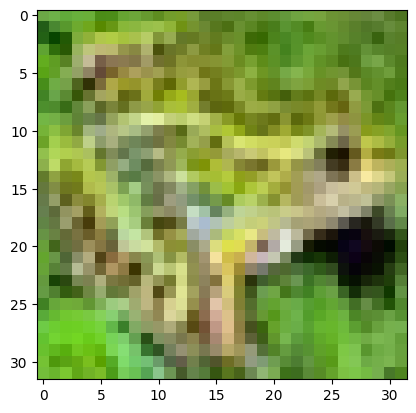

frog


In [9]:
image_show(X_batch[0])
print(classes[y_batch[0].item()])

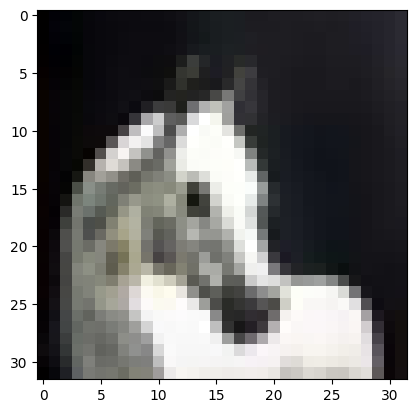

horse


In [10]:
image_show(X_batch[5])
print(classes[y_batch[5].item()])

In [11]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn = torch.nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
       )
        self.lin = torch.nn.Sequential(
            nn.Linear(256*4*4, 5000),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(5000, 3000),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(3000, 10),
       )
    def forward(self, x):
        x = self.cnn(x)
        x = x.reshape(x.shape[0],-1)
        x = self.lin(x)
        return x

In [12]:
model = CNN()
for param in model.parameters():
  print(param.shape)
  print(param.requires_grad)
  break

torch.Size([64, 3, 3, 3])
True


In [13]:
model.cnn(X_batch).shape

torch.Size([100, 256, 4, 4])

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [16]:
summary(model, input_size = (3, 32, 32), batch_size = 100)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [100, 64, 32, 32]           1,792
       BatchNorm2d-2          [100, 64, 32, 32]             128
              ReLU-3          [100, 64, 32, 32]               0
         MaxPool2d-4          [100, 64, 16, 16]               0
            Conv2d-5         [100, 128, 16, 16]          73,856
       BatchNorm2d-6         [100, 128, 16, 16]             256
              ReLU-7         [100, 128, 16, 16]               0
         MaxPool2d-8           [100, 128, 8, 8]               0
            Conv2d-9           [100, 256, 8, 8]         295,168
      BatchNorm2d-10           [100, 256, 8, 8]             512
             ReLU-11           [100, 256, 8, 8]               0
        MaxPool2d-12           [100, 256, 4, 4]               0
           Linear-13                [100, 5000]      20,485,000
             ReLU-14                [10

In [17]:
epochs = np.arange(1, 21)

loss_list = []

for epoch in epochs:

    loss_epoch = []
    acc_epoch = []

    model.train()

    for k, (image, label) in enumerate(train_loader):

        image = image.to(device)
        label = label.to(device)

        output = model(image)
        loss = criterion(output, label)

        predict = torch.argmax(output, dim=1)
        accuracy = (predict == label).cpu().numpy().mean()
        acc_epoch.append(accuracy)

        loss_epoch.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_list.append(np.mean(loss_epoch))

    print(f'Epoch:{epoch}, Loss:{np.mean(loss_epoch):.4f}, Train_accuracy:{np.mean(acc_epoch):.4f}')

Epoch:1, Loss:1.5702, Train_accuracy:0.4443
Epoch:2, Loss:1.0896, Train_accuracy:0.6117
Epoch:3, Loss:0.9004, Train_accuracy:0.6841
Epoch:4, Loss:0.7905, Train_accuracy:0.7264
Epoch:5, Loss:0.7003, Train_accuracy:0.7575
Epoch:6, Loss:0.6366, Train_accuracy:0.7803
Epoch:7, Loss:0.5630, Train_accuracy:0.8048
Epoch:8, Loss:0.5075, Train_accuracy:0.8252
Epoch:9, Loss:0.4460, Train_accuracy:0.8465
Epoch:10, Loss:0.4040, Train_accuracy:0.8616
Epoch:11, Loss:0.3477, Train_accuracy:0.8804
Epoch:12, Loss:0.3106, Train_accuracy:0.8933
Epoch:13, Loss:0.2718, Train_accuracy:0.9063
Epoch:14, Loss:0.2486, Train_accuracy:0.9144
Epoch:15, Loss:0.2222, Train_accuracy:0.9252
Epoch:16, Loss:0.1953, Train_accuracy:0.9344
Epoch:17, Loss:0.1802, Train_accuracy:0.9387
Epoch:18, Loss:0.1670, Train_accuracy:0.9435
Epoch:19, Loss:0.1519, Train_accuracy:0.9487
Epoch:20, Loss:0.1412, Train_accuracy:0.9534


In [18]:
model.eval()

losses = []

with torch.no_grad():
    for k, (image, label) in enumerate(test_loader):
        image = image.to(device)
        label = label.to(device)
        output = model(image)
        loss = criterion(output, label)
        losses.append(loss.item())

In [19]:
print("TEST LOSS:  ", np.mean(losses))

TEST LOSS:   0.6885798141360283


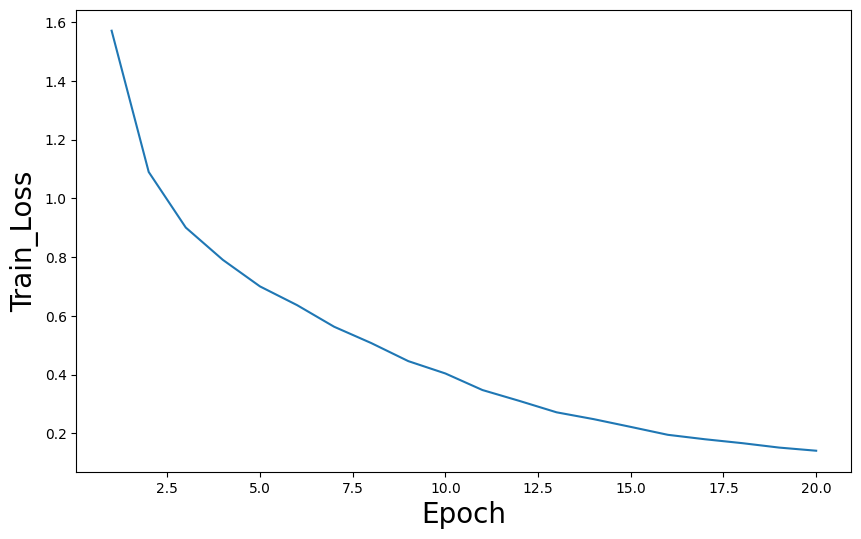

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_list)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Train_Loss', fontsize=20)
plt.show()